In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import time
import requests
#Uni√≥n de csv
import os
import glob
#Bibliotecas para el An√°lisis de Sentimiento
import nltk
from textblob import TextBlob
#import vaderSentiment
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #No est√° funcionando
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [9]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### Limpieza del texto

Una vez extra√≠dos los tweets en la fase de extracci√≥n, formamos el df "analisis_sentimiento.csv". A partir de aqu√≠ realizamos la limpieza del texto para la traducci√≥n al ingl√©s y posterior an√°lisis.

In [ ]:
#Referencia de limpiexa de Tweets: https://ourcodingclub.github.io/2018/12/10/topic-modelling-python.html#clean

In [133]:
#Comenzamos desde este punto para la limpieza del texto
df_sent = pd.read_csv('datos/analisis_sentimiento.csv', index_col=0)
#df_sent.drop('Unnamed: 0', axis=1, inplace=True)
df_sent.head()

emisor      mencionado  \
0     Postematico             NaN   
1   2016carranque       CienciaOn   
2       unsamwich             NaN   
3  LaresAndalucia    Laresmayores   
4      KoldoMendi  HoffmannMethod   

                                               texto     rt  \
0  ‚ö†Ô∏è Si realizas estos ejercicios podr√°s tener u...  False   
1  RT @CienciaOn: Confirmado: viajar a la velocid...   True   
2  Dicen que tener las orejas grandes es signo de...  False   
3  RT @Laresmayores: Entrega del #Premio #Asociac...   True   
4  RT @HoffmannMethod: El M√©todo Hoffmann es un m...   True   

                  localizacion  
0  Comunidad de Madrid, Espa√±a  
1  Comunidad de Madrid, Espa√±a  
2             Marbella, Espa√±a  
3                          NaN  
4  Madrid, Comunidad de Madrid

In [134]:
#Funci√≥n para eliminar los emojis de un string
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [141]:
#Definici√≥n y eliminaci√≥n de caracteres especiales
special_characters = r'!"$%&\'()*+-./<=>?[\\]^_`{|}~‚Ä¢@'

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
def clean_tweets(lst):
    # remove spacing
    lst = lst.strip()
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")
    return lst

In [135]:
#En primer lugar aplicamos la funci√≥n para eliminar los emojis
df_sent['texto_limpio'] = df_sent['texto'].map(lambda x: remove_emojis(x))

In [142]:
#Aplicamos la funci√≥n de limpiar el texto
df_sent['texto_limpio'] = df_sent['texto_limpio'].map(lambda x: clean_tweets(x))

In [144]:
#Eliminamos los caracteres de puntuaci√≥n como una etapa extra a partir de la biblioteca "string"
df_sent['texto_limpio'] = df_sent['texto_limpio'].map(lambda x: ''.join([i for i in x if i not in string.punctuation]))

In [151]:
#Volvemos a quitar los posibles espacios al inicio del texto
df_sent['texto_limpio'] = df_sent['texto_limpio'].apply(lambda x: x.strip())

In [147]:
#Comprobamos la diferencia entre el texto sin tratar y el texto una vez eliminado caracteres especiales y emojis
df_sent['texto'][0]

'‚ö†Ô∏è Si realizas estos ejercicios podr√°s tener un mejor envejecimiento a partir de los 30 https://t.co/MI8NnKk96Q'

In [148]:
df_sent['texto_limpio'][0]

'Si realizas estos ejercicios podr√°s tener un mejor envejecimiento a partir de los 30 '

In [154]:
#Guardamos el df una vez limpio antes del an√°lisis de sentmiento
df_sent.to_csv('datos/analisis_sentimiento.csv')

### Biblioteca TextBlob

In [22]:
#Traduzco a ingl√©s cada uno de los textos para aplicarle la biblioteca de sentimiento de textblob posteriormente
#Realizamos una prueba preliminar para comprobar que funciona con uno de los registros de nuestro df
analysis = TextBlob(df_sent['texto'][0])
eng=analysis.translate(to='en')
print(eng.sentiment.polarity)

0.5


In [61]:
#Factorizamos el an√°lisis con TextBlob
def sentiment_analyzer_scores_textblob(text):
    analysis = TextBlob(text)
    eng=analysis.translate(to='en')
    lb = eng.sentiment.polarity
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1

In [65]:
#Hacemos una prueba del funcionamiento
sentiment_analyzer_scores_textblob(df_sent['texto_limpio'][1])

1

In [3]:
#Factorizamos el an√°lisis con TextBlob pero con el valor bruto
def sentiment_analyzer_scores_textblob(text):
    analysis = TextBlob(text)
    eng=analysis.translate(to='en')
    lb = eng.sentiment.polarity
    time.sleep(0.3)
    return lb

In [9]:
sentiment_analyzer_scores_textblob(df_sent['texto_limpio'][1])

0.4

### Biblioteca VADER

In [5]:
#Referencia: https://towardsdatascience.com/almost-real-time-twitter-sentiment-analysis-with-tweep-vader-f88ed5b93b1c
#Para el uso de esta biblioteca tenemos que realizar en primer lugar una traducci√≥n del Espa√±ol al Ingl√©s
#Importamos la API de Google traslator en Python (Googletrans): https://py-googletrans.readthedocs.io/en/latest/
#Para poder instalarlo debe hacerse con la versi√≥n pip adecuada, para ello se utiliza en el prompt de conda:
#>python -m pip install googletrans
from googletrans import Translator
translator = Translator()

In [6]:
#Prueba de funcionamiento
translator.translate('hola, todo bien?').text

'hello, all right?'

In [20]:
df_sent['texto'][0]

'‚ö†Ô∏è Si realizas estos ejercicios podr√°s tener un mejor envejecimiento a partir de los 30 https://t.co/MI8NnKk96Q'

In [21]:
translator.translate(df_sent['texto'][0]).text

'‚ö†Ô∏è If you perform these exercises can have a better aging from 30 https://t.co/MI8NnKk96Q'

In [22]:
text = translator.translate(df_sent['texto'][0]).text
sid = SentimentIntensityAnalyzer()
ss = sid.polarity_scores(text)
ss
#Con TextBlob se obten√≠a para este tweet: 0.5

{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'compound': 0.4404}

In [23]:
#Probamos una forma compuesta para factorizar el an√°lisis
sid.polarity_scores(translator.translate(df_sent['texto'][0]).text)
#Con TextBlob se obten√≠a para este tweet: 0.4

{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'compound': 0.4404}

Factorizamos este desarrollo para obtener una escala de tres rangos [-1, 0, 1] a partir del 'Compound':  
[-1 to 0): negativo,  
[0]: neutral  
(0 to +1]: positivo

In [24]:
#En la funci√≥n detecta si el idioma es ingl√©s (No hace nada) u otro idioma (traduce al ingl√©s)
sid = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores_vader(text, engl=True):
    if engl:
        trans = text
    else:
        trans = translator.translate(text).text
    score = sid.polarity_scores(trans)
    lb = score['compound']
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1

In [10]:
#Factorizamos con el resultado en bruto
translator = Translator()
sid = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores_vader_bruto(text, engl=True):
    trans = translator.translate(text).text
    score = sid.polarity_scores(trans)
    lb = score['compound']
    time.sleep(0.3)
    return lb

In [25]:
sentiment_analyzer_scores_vader(df_sent['texto'][0])

0

In [27]:
sentiment_analyzer_scores_vader_bruto(df_sent['texto_limpio'][0])

0.4404

### Aplicamos el an√°lisis de sentimiento con las funciones desarrolladas

In [1]:
#Vamos a localizar d√≥nde est√° fallando en el caso del m√©todo Vader
#Referencia: https://stackoverflow.com/questions/26660313/pandas-location-of-a-row-with-error
'''
import time
for i, row in enumerate(df_sent['texto_limpio']):
    try:
        sentiment_analyzer_scores_vader(row)
    except Exception as e: 
        time.sleep(5)
        print('Error at index {}: {!r}'.format(i, row))
        print(e)
'''
#Se comprueba al aplicar las funciones que la API de GoogleTrans tiene una limitaci√≥n de conexiones, lo que hace que a partir del
#registro 358 se produzca un error al analizar el sentimiento al no poder traducir previamente el texto.

"\nimport time\nfor i, row in enumerate(df_sent['texto_limpio']):\n    try:\n        sentiment_analyzer_scores_vader(row)\n    except Exception as e: \n        time.sleep(5)\n        print('Error at index {}: {!r}'.format(i, row))\n        print(e)\n"

In [12]:
texto = 'Si realizas estos ejercicios podr√°s tener un mejor envejecimiento a partir de los 30'
sentiment_analyzer_scores_textblob(texto)

0.5

In [2]:
#Probamos como funciona con TextBlob
#Referencia: https://stackoverflow.com/questions/26660313/pandas-location-of-a-row-with-error
'''
for i, row in enumerate(df_sent['texto_limpio']):
    try:
        sentiment_analyzer_scores_textblob(row)
    except Exception as e:
        time.sleep(10)
        print('Error at index {}: {!r}'.format(i, row))
        print(e)
'''
#Se comprueba que Textblob internamente tambi√©n utiliza la api de googleTrans para realizar la traducci√≥n, por lo que al tener
#el l√≠mite de conexiones falla la traducci√≥n y por tanto la funci√≥n de an√°lisis de sentimiento

"\nfor i, row in enumerate(df_sent['texto_limpio']):\n    try:\n        sentiment_analyzer_scores_textblob(row)\n    except Exception as e:\n        time.sleep(10)\n        print('Error at index {}: {!r}'.format(i, row))\n        print(e)\n"

### M√©todos alternativos de Traducci√≥n de los Tweets  
## YADEX
Intentamos utilizar otras Apis de traducci√≥n para salvar los l√≠mites de conexi√≥n de google traslato. 
Yadex no tiene aparentemente limite de conexiones utilizando para la conexi√≥n 'get' con la biblioteca request.  
Necesitamos registrarnos en yedex y conseguir una ApiKey.  
 - Yandex Translation (https://tech.yandex.com/translate/)


In [3]:
#hay que instalarlo con la versi√≥n adecuado de pip en el prompt de conda
#>python -m pip install yandex
#!pip install yandex

#### Conectamos con la API de Yandex  
Referencia: https://tech.yandex.com/translate/doc/dg/reference/translate-docpage/

In [4]:
#Factorizamos la conexi√≥n
sid = SentimentIntensityAnalyzer()
def traslate(text, key):
    key=key
    lang = 'en'
    url_yandex ="https://translate.yandex.net/api/v1.5/tr.json/translate?key=%s&text=%s&lang=%s" % (key,text,lang)
    time.sleep(0.3)
    response = requests.get(url_yandex, timeout=None)
    response_data = eval(response.content.decode('utf-8'))
    lb = response_data['text'][0]
    return lb

def sentiment_analyzer_scores_vader(lb):
    lb = traslate(lb)
    score = sid.polarity_scores(lb)
    return score['compound']

In [5]:
#Realizamos una prueba para comprobar que funciona con un resultado de nuestro df
sentiment_analyzer_scores_vader(df_sent['texto_limpio'][3])

0.5106

Realizamos la prueba para introducir otra columna con el score del an√°lisis de sentimiento hasta que de fallo

In [6]:
#Factorizamos con otra funci√≥n para evitar que falle, introduciendo un valor Nan sino consigue obtener la polaridad del
#an√°lisis de sentimiento y si falla espera un lapso de tiempo para volver a conectar con la api de yandex
def score(row):
    try:
        if True:
            score = sentiment_analyzer_scores_vader(row)
            return score 
        else:
            return np.nan
    except Exception as e: 
        time.sleep(5)
        pass

In [86]:
#Para controlar el proceso y comprobar d√≥nde puede fallar, se realiza el an√°lisis por etapas cada 1000 registros
#Cada 1000 registros se guarda el csv para reiniciar desde el potencial fallo
#Despu√©s de cada iteraci√≥n se genera un lapso de conexi√≥n para evistar fallos de la API
df_prueba=pd.DataFrame()

for i in np.arange(1000,11000,1000):
    start_time = time.time()
    df_prueba = df_sent[i-1000:i]
    df_prueba['sent_score'] = df_prueba['texto_limpio'].map(lambda x: score(x))
    df_prueba = df_prueba.reset_index(drop=True)
    df_prueba.to_csv(r"..\datos\sent_score\Analisis_sentimiento"+'_'+str(i-1000)+'-'+str(i)+".csv", index=True)
    print('Registrados el score de',str(i-1000),'hasta',str(i),'registros')
    print("--- %s minutos  ---" % (round((time.time() - start_time)/60,2)))
    df_prueba=pd.DataFrame()
    time.sleep(0.5)

C:\Users\JoseLuisFernandez\Anaconda3\envs\PLN\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Registrados el score de 0 hasta 1000 registros
--- 14.01 minutos  ---
Registrados el score de 1000 hasta 2000 registros
--- 14.28 minutos  ---
Registrados el score de 2000 hasta 3000 registros
--- 14.06 minutos  ---
Registrados el score de 3000 hasta 4000 registros
--- 14.08 minutos  ---
Registrados el score de 4000 hasta 5000 registros
--- 21.88 minutos  ---
Registrados el score de 5000 hasta 6000 registros
--- 95.9 minutos  ---
Registrados el score de 6000 hasta 7000 registros
--- 96.11 minutos  ---
Registrados el score de 7000 hasta 8000 registros
--- 96.1 minutos  ---
Registrados el score de 8000 hasta 9000 registros
--- 95.84 minutos  ---
Registrados el score de 9000 hasta 10000 registros
--- 94.44 minutos  ---


### Uni√≥n de csv

In [25]:
#Concatenamos todos los csv guardados
#Leer todos los ficheros del directorio e importarlos a un dataframe
path_csv = r'..\datos\sent_score'
all_files = glob.glob(os.path.join(path_csv, "*.csv"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
df_sent = pd.concat(df_from_each_file)

In [33]:
#Elimino columnas sin inter√©s
df_sent.drop('Unnamed: 0',1,inplace=True)
#Reseteo el √≠ndice
df_sent.reset_index(drop=True,inplace=True)

In [36]:
df_sent.describe()

sent_score
count  9886.000000
mean      0.113758
std       0.411297
min      -0.955600
25%       0.000000
50%       0.000000
75%       0.440400
max       0.976800

### Gr√°ficos del an√°lisis de sentimiento  
Referencia: https://towardsdatascience.com/statistical-sentiment-analysis-for-survey-data-using-python-9c824ef0c9b0

In [6]:
df_sent = pd.read_csv('analisis_sentimiento_full_v1.csv', index_col=0)

C:\Users\JoseLuisFernandez\Anaconda3\envs\PLN\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\JoseLuisFernandez\Anaconda3\envs\PLN\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


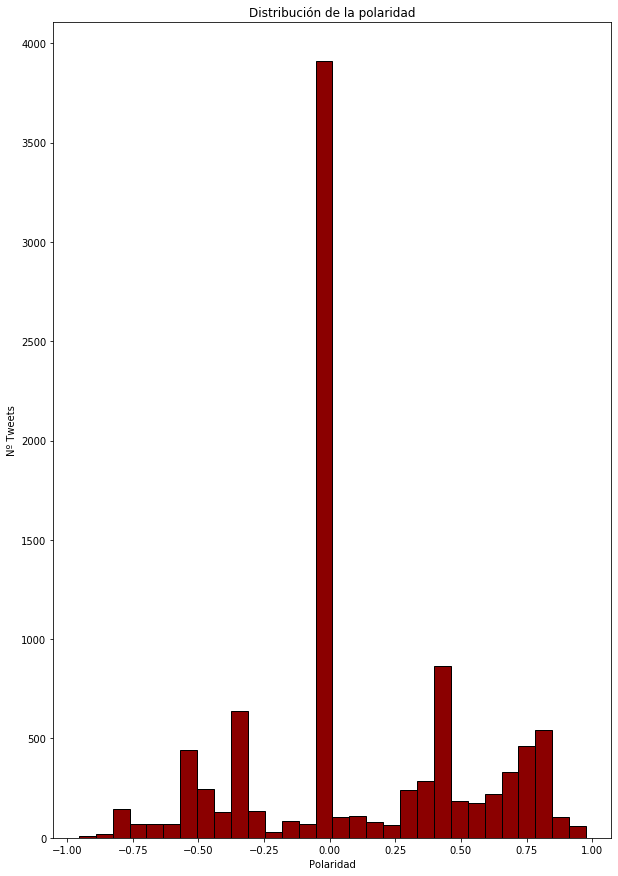

In [12]:
#Polarity Distribution for dffilter
plt.hist(df_sent['sent_score'], color = 'darkred', edgecolor = 'black', density=False,
         bins = int(30))
plt.title('Distribuci√≥n de la polaridad')
plt.xlabel("Polaridad")
plt.ylabel("N¬∫ Tweets")

from pylab import rcParams
rcParams['figure.figsize'] = 10,15

Los resultados estan totalmente influenciados por demasiados comentarios neutrales que afectar√°n la precisi√≥n del an√°lisis.  
Vamos a aislar los tweets neutrales para facilitar el an√°lisis.

In [7]:
dffilter = df_sent[df_sent.sent_score != 0]

In [10]:
dffilter.describe()

sent_score
count  6014.000000
mean      0.187000
std       0.514198
min      -0.955600
25%      -0.318200
50%       0.381800
75%       0.651575
max       0.976800

C:\Users\JoseLuisFernandez\Anaconda3\envs\PLN\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\JoseLuisFernandez\Anaconda3\envs\PLN\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


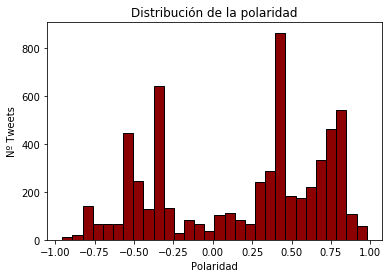

In [11]:
#Polarity Distribution for dffilter
plt.hist(dffilter['sent_score'], color = 'darkred', edgecolor = 'black', density=False,
         bins = int(30))
plt.title('Distribuci√≥n de la polaridad')
plt.xlabel("Polaridad")
plt.ylabel("N¬∫ Tweets")

from pylab import rcParams
rcParams['figure.figsize'] = 10,15

In [59]:
# Funci√≥n para mapear los colores como una lista de la lista de entrada de x variables
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l>0:
            cols.append('green')
        elif l==0:
            cols.append('blue')
        else:
            cols.append('red')
    return cols
# Create the colors list using the function above
cols=pltcolor(df_sent['sent_score'])

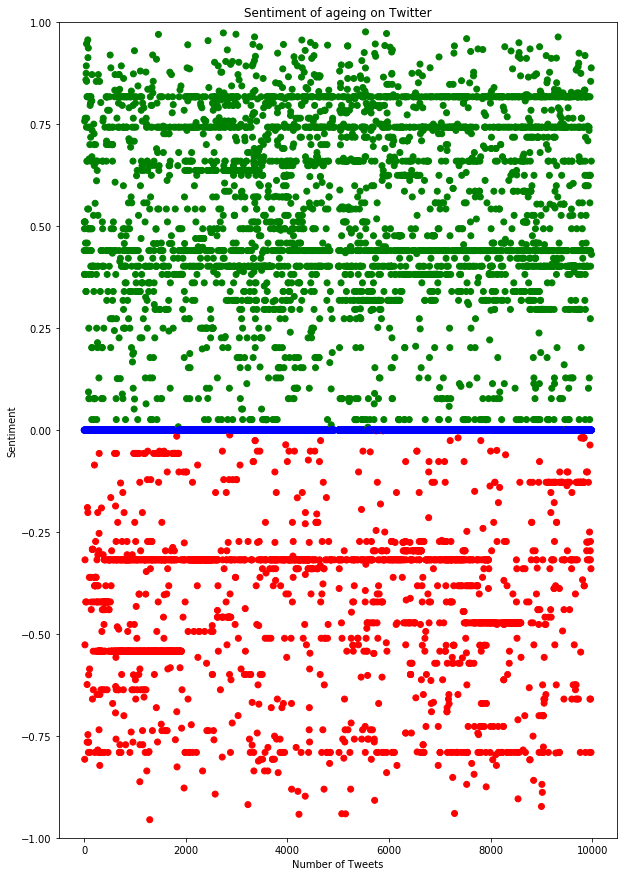

In [65]:
from matplotlib import pyplot as plt
plt.scatter(df_sent.index.tolist(), df_sent['sent_score'], c=cols)
plt.ylim([-1, 1])
plt.title("Sentiment of ageing on Twitter")
plt.xlabel("Number of Tweets")
plt.ylabel("Sentiment")
plt.show()

### Detecci√≥n de palabras m√°s mencionadas en las distintas comunidades

### Comunidad Rojaüî¥

In [9]:
#Identificamos la comunidad 1 a partir del usuario 'sninobecerra'
comunidad_roja = df_sent[(df_sent.emisor == 'sninobecerra') | (df_sent.mencionado == 'sninobecerra')]

In [10]:
## Identificamos palabras m√°s comunes
freq = pd.Series(' '.join(comunidad_roja['texto_limpio']).split()).value_counts()[:20]
freq

de                759
y                 751
el                750
la                377
envejecimiento    376
una               376
natalidad         376
baja              375
no                375
El                375
es                375
estructura        374
PIB               374
problema          374
descenso          374
sino              374
productividad     374
basada‚Ä¶           373
en                  3
que                 3
dtype: int64

Vamos a Procesar el texto para eliminar las palabras sin informaci√≥n (stopwords)

In [11]:
#Importamos las librer√≠as necesarias para el procesado de textos
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

In [12]:
#Se puede crear mis propias palabras a la lista de stopwords
main_sw= pd.read_csv("palabrasclave\stopwordscc.csv")
main_sw= main_sw['stopwordcc'].tolist()

In [13]:
##Creamos una lista de palabras sin informaci√≥n (stopwords) que nos proporciona el corpus de nltk
stop_words = set(stopwords.words("spanish"))
##A√±adimos las palabras personalizadas a la lista de stopwords
stop_words = stop_words.union(main_sw)

In [19]:
#Realizamos una limpieza extra de palabras a las ya realizada en el procesado del texto anterior
corpus = []
text = comunidad_roja['texto_limpio']

for i in text:
    #Convert to lowercase
    i = i.lower()
    
    #remove tags (">","<")
    i=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",i)
    
    # remove special characters and digits
    i=re.sub("(\\d|\\W)+"," ",i)
    
    ##Convert to list from string
    i = i.split()
    
    ##Stemming
    #ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in i if not word in stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [27]:
#corpus[22]
freq = pd.Series(' '.join(corpus).split()).value_counts()[:10]
freq

envejecimiento    377
natalidad         376
baja              375
pib               374
productividad     374
problema          374
sino              374
estructura        374
descenso          374
basada            374
dtype: int64

In [26]:
#A√±adimos una Nube de palabras para hacerlo m√°s visual
#Instalamos la libreria wordcloud
#!pip install wordcloud

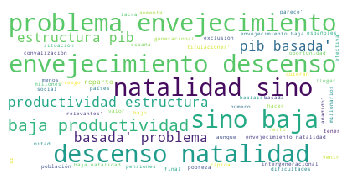

In [34]:
#Creamos una nube de palabras para hacernos una idea de las m√°s habituales
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1);
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("wc_roja.png", dpi=900);

### Comunidad verdeüçè

In [29]:
#Identificamos la comunidad 2 a partir del usuario 'elbotiquinmx'
comunidad_verde = df_sent[(df_sent.emisor == 'elbotiquinmx') | (df_sent.mencionado == 'elbotiquinmx')]
comunidad_verde.head()

emisor    mencionado  \
3060        Piba roja  elbotiquinmx   
3536    cartamarciana  elbotiquinmx   
3569    gblancocampos  elbotiquinmx   
3647     AdrianaT9735  elbotiquinmx   
3725  IgnacioAncheyta  elbotiquinmx   

                                                  texto    rt    localizacion  \
3060  RT @elbotiquinmx: Esto las convierte en una fu...  True          M√âXICO   
3536  RT @elbotiquinmx: Esto las convierte en una fu...  True  Colima, M√©xico   
3569  RT @elbotiquinmx: Esto las convierte en una fu...  True             NaN   
3647  RT @elbotiquinmx: Esto las convierte en una fu...  True             NaN   
3725  RT @elbotiquinmx: Esto las convierte en una fu...  True          Mexico   

                                           texto_limpio  sent_score  
3060  Esto las convierte en una fuente perfecta para...       0.296  
3536  Esto las convierte en una fuente perfecta para...       0.296  
3569  Esto las convierte en una fuente perfecta para...       0.296  
3647  Esto las convierte en una fuente perfecta para...       0.296  
3725  Esto las convierte en una fuente perfecta para...       0.296

In [30]:
#Realizamos una limpieza extra de palabras a las ya realizada en el procesado del texto anterior
corpus_v = []
text = comunidad_verde['texto_limpio']

for i in text:
    #Convert to lowercase
    i = i.lower()
    
    #remove tags (">","<")
    i=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",i)
    
    # remove special characters and digits
    i=re.sub("(\\d|\\W)+"," ",i)
    
    ##Convert to list from string
    i = i.split()
    
    ##Stemming
    #ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in i if not word in stop_words] 
    text = " ".join(text)
    corpus_v.append(text)

In [32]:
#corpus[22]
freq = pd.Series(' '.join(corpus_v).split()).value_counts()[:20]
freq

envejeciendo      174
lamentamos        174
si                174
decirte           174
envejecimiento     42
convierte          39
fuente             39
luchar             39
perfecta           39
vida                2
q                   2
hecho               2
opues               1
disfrutar           1
nacemos             1
fine                1
horabuena           1
fisiolog√≠a          1
pues                1
entramos            1
dtype: int64

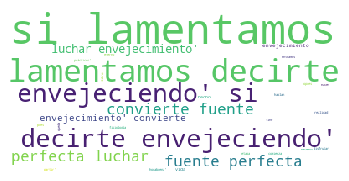

In [33]:
#Creamos una nube de palabras para hacernos una idea de las m√°s habituales
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus_v))
print(wordcloud)
fig = plt.figure(1);
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("wc_verde.png", dpi=900);

### Comunidad moradaüéµ y naranjaüçä

In [65]:
#Identificamos la comunidad 2 a partir del usuario 'elbotiquinmx'
comunidad_morada = df_sent[(df_sent['emisor'].str.contains('gringo')) | (df_sent['mencionado'].str.contains('gringo'))]
comunidad_morada.head()

emisor     mencionado  \
399           Dronhh  yo gringoloco   
589     Fabi46113796  yo gringoloco   
642        Luzmi Bol  yo gringoloco   
654       molina die  yo gringoloco   
683  PedrazasDavid22  yo gringoloco   

                                                 texto    rt     localizacion  \
399  RT @yo_gringoloco: Estudios demuestran que la ...  True              NaN   
589  RT @yo_gringoloco: Estudios demuestran que la ...  True              NaN   
642  RT @yo_gringoloco: Estudios demuestran que la ...  True  La Paz, Bolivia   
654  RT @yo_gringoloco: Estudios demuestran que la ...  True              NaN   
683  RT @yo_gringoloco: Estudios demuestran que la ...  True          Bolivia   

                                          texto_limpio  sent_score  
399  Estudios demuestran que la falta de helic√≥pter...     -0.3182  
589  Estudios demuestran que la falta de helic√≥pter...     -0.3182  
642  Estudios demuestran que la falta de helic√≥pter...     -0.3182  
654  Estudios demuestran que la falta de helic√≥pter...     -0.3182  
683  Estudios demuestran que la falta de helic√≥pter...     -0.3182

In [66]:
#Realizamos una limpieza extra de palabras a las ya realizada en el procesado del texto anterior
corpus_m = []
text = comunidad_morada['texto_limpio']

for i in text:
    #Convert to lowercase
    i = i.lower()
    
    #remove tags (">","<")
    i=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",i)
    
    # remove special characters and digits
    i=re.sub("(\\d|\\W)+"," ",i)
    
    ##Convert to list from string
    i = i.split()
    
    ##Stemming
    #ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in i if not word in stop_words] 
    text = " ".join(text)
    corpus_m.append(text)

In [67]:
freq = pd.Series(' '.join(corpus_m).split()).value_counts()[:20]
freq

falta             181
estudios          181
demuestran        181
helic√≥ptero       181
envejecimiento    181
causa             180
prematuro         180
seguiremos        180
nomasevo          180
informando        180
http              179
poquito             1
redacci√≥n           1
acelera             1
discuklpe           1
corregir√≠a          1
dtype: int64